### Линейная комбинация. Прогноз размещения в месяц на площадке (регионы + уровни субъекта суммы )

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
#Немоного изменим параметры вывода графиков
rcParams['figure.figsize'] = 18,10

In [3]:
data = pd.read_excel('РегионыУровниСубьектаСуммы.xlsx')
data.head()

,RegCode,M1,M2,M3,M4,M5,M6,M7,M8,M9,...,M27,M28,M29,M30,M31,M32,M33,M34,M35,M36
0,11,0.0,0.0,0.0,1606575.1,0.0,0.0,0.00,0.0,5.669180e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
1,12,0.0,0.0,0.0,0.0,0.0,0.0,0.00,74203900.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
2,13,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.812058e+07,3.947885e+06,6.805182e+06,0.0,0.0
3,21,0.0,0.0,0.0,0.0,0.0,0.0,1523999.00,1331500.0,9.015217e+08,...,2.291224e+09,1.527199e+09,1.132434e+06,3.949155e+05,2.851155e+05,1.843764e+06,6.179422e+05,4.131811e+05,0.0,0.0
4,22,0.0,0.0,0.0,0.0,0.0,0.0,275697.87,9605420.0,2.402028e+06,...,1.666605e+07,6.968792e+06,5.408317e+08,4.562751e+08,2.796425e+09,3.138505e+09,3.513853e+09,1.736769e+09,0.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 37 columns):
RegCode    243 non-null int64
M1         243 non-null float64
M2         243 non-null float64
M3         243 non-null float64
M4         243 non-null float64
M5         243 non-null float64
M6         243 non-null float64
M7         243 non-null float64
M8         243 non-null float64
M9         243 non-null float64
M10        243 non-null float64
M11        243 non-null float64
M12        243 non-null float64
M13        243 non-null float64
M14        243 non-null float64
M15        243 non-null float64
M16        243 non-null float64
M17        243 non-null float64
M18        243 non-null float64
M19        243 non-null float64
M20        243 non-null float64
M21        243 non-null float64
M22        243 non-null float64
M23        243 non-null float64
M24        243 non-null float64
M25        243 non-null float64
M26        243 non-null float64
M27        243 non-null float64
M

In [5]:
melt = data.melt(id_vars='RegCode', var_name='Month', value_name='Proc')

melt['Month'] = melt['Month'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['RegCode', 'Month'])
melt.head()

,RegCode,Month,Proc
0,11,1,0.0
243,11,2,0.0
486,11,3,0.0
729,11,4,1606575.1
972,11,5,0.0


In [6]:
month_start=29
month_end=34
s='Procedures (week '+str(month_start)+ ' - '+str(month_end)+ ')'

In [7]:
import copy

In [8]:
melt2 =  melt.copy()
melt2['Last_Month_Proc'] = melt2.groupby(['RegCode'])['Proc'].shift()
melt2['Last_Month_Diff'] = melt2.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt2 = melt2.dropna()
melt2.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff
486,11,3,0.0,0.0,0.0
729,11,4,1606575.1,0.0,0.0
972,11,5,0.0,1606575.1,1606575.1
1215,11,6,0.0,0.0,-1606575.1
1458,11,7,0.0,0.0,0.0


In [9]:
procedures = []
for Month in range(0, month_start):
    val=melt[melt['Month'] == Month]
    total=sum(val['Proc'])
    procedures.append(total)

In [10]:
proceduresAll = []
for Month in range(0,month_end):
    val=melt[melt['Month'] == Month]
    total=sum(val['Proc'])
    proceduresAll.append(total)

In [11]:
melt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8262 entries, 486 to 8747
Data columns (total 5 columns):
RegCode            8262 non-null int64
Month              8262 non-null int32
Proc               8262 non-null float64
Last_Month_Proc    8262 non-null float64
Last_Month_Diff    8262 non-null float64
dtypes: float64(3), int32(1), int64(1)
memory usage: 355.0 KB


In [12]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [13]:
%%time
mean_errorB = []
total_errorB = []
ProcB = copy.copy(procedures)
predict_ProcB = copy.copy(procedures)
abs_pr_errorB = []
for Month in range(month_start, month_end):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    yts=val['Proc']
    
    p = val['Last_Month_Proc'].values
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (Month, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorB.append(error)
    total_errorB.append(abs_error)
    ProcB.append(total_yts)
    predict_ProcB.append(total_p)
    abs_pr_errorB.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error = %.5f' % np.mean(total_errorB))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorB))

Month 29 - Error 2.07556, Real Total 170517288029.3 - Predict Total 133159940682.1, Abs Error 37357347347.2, Persent - 21.9
Month 30 - Error 1.93354, Real Total 138610185794.3 - Predict Total 170517288029.3, Abs Error 31907102235.0, Persent - 23.0
Month 31 - Error 2.79240, Real Total 114863526233.8 - Predict Total 138610185794.3, Abs Error 23746659560.5, Persent - 20.7
Month 32 - Error 2.98329, Real Total 132186973999.4 - Predict Total 114863526233.8, Abs Error 17323447765.6, Persent - 13.1
Month 33 - Error 2.68341, Real Total 121359958523.1 - Predict Total 132186973999.4, Abs Error 10827015476.2, Persent - 8.9
Mean Error = 2.49364
Mean Abs Error = 24232314476.90397
Mean Abs Error persent = 17.52560
Wall time: 20 ms


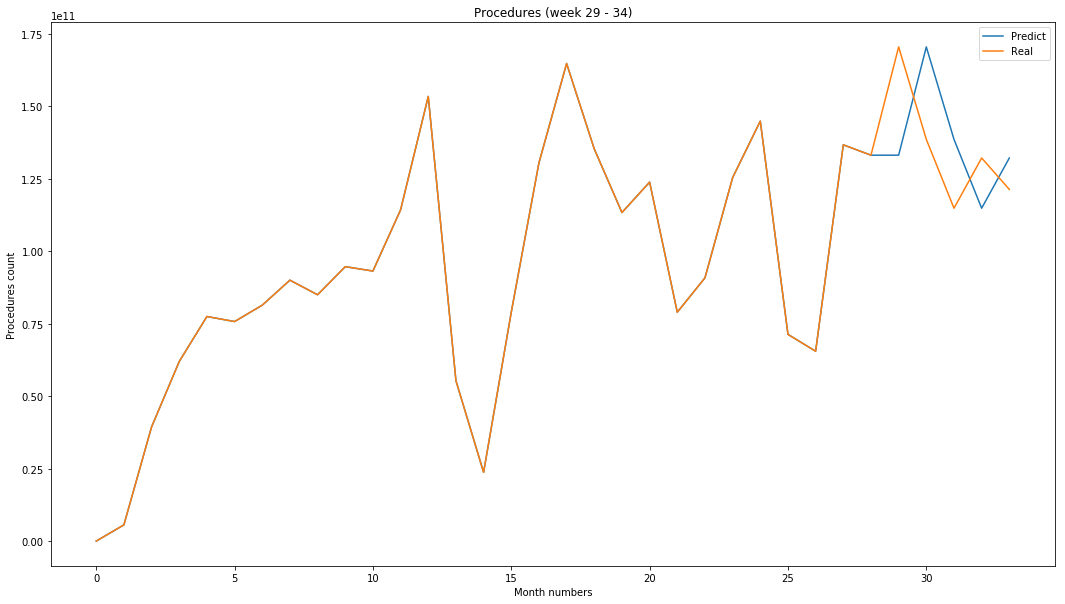

In [14]:

plt.plot(predict_ProcB)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

(600000000, 220000000000)

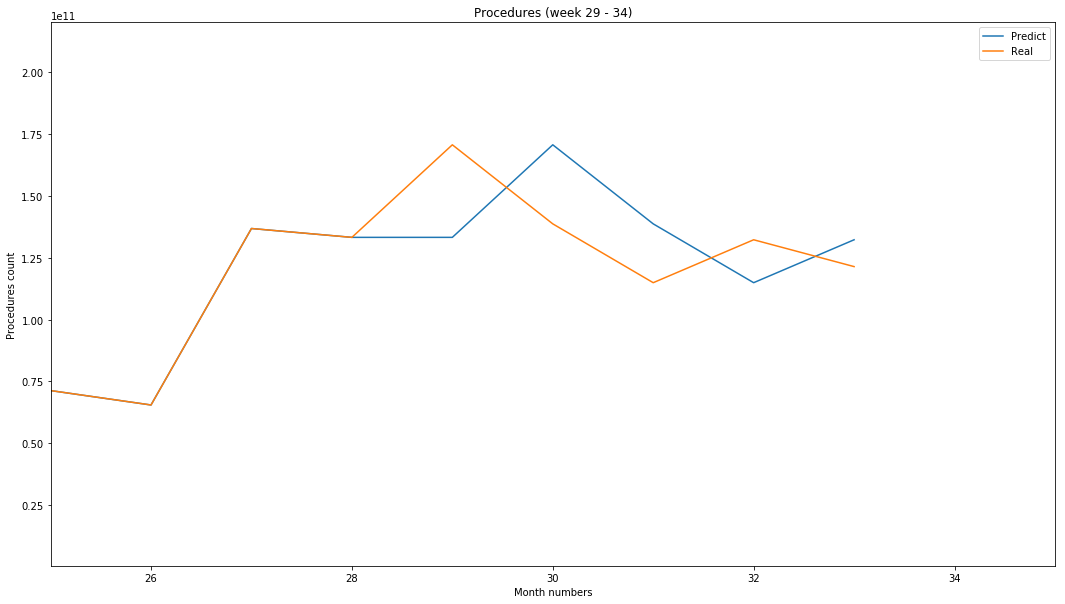

In [20]:
plt.plot(predict_ProcB)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))
plt.xlim(25, 35)
plt.ylim(600000000, 220000000000)

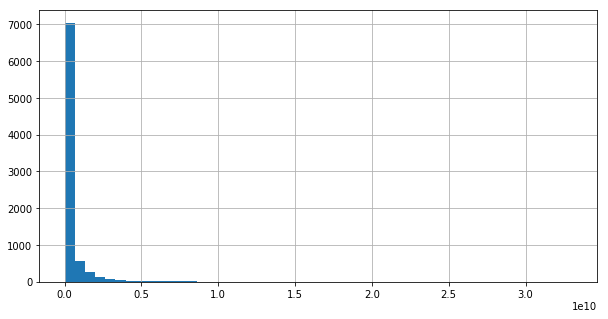

In [21]:
melt2['Proc'].hist(bins=50, figsize=(10,5))

In [22]:
%%time
mean_errorLR2 = []
mean_errorRF2 = []
mean_errorGB2 = []

mean_errorEC2 = []


total_errorLR2 = []
predict_ProcLR2 = copy.copy(procedures)
abs_pr_errorLR2 = []

total_errorRF2 = []
predict_ProcRF2 = copy.copy(procedures)
abs_pr_errorRF2 = []

total_errorGB2 = []
predict_ProcGB2 = copy.copy(procedures)
abs_pr_errorGB2 = []

total_errorEC2 = []
predict_ProcEC2 = copy.copy(procedures)
abs_pr_errorEC2 = []
for Month in range(month_start, month_end):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR2 = rmsle(yts, plr)
    abs_errorLR2 = abs(total_yts-total_plr)
    abs_prLR2 = abs_errorLR2/total_yts*100
    
    mean_errorLR2.append(errorLR2)
    total_errorLR2.append(abs_errorLR2)
    predict_ProcLR2.append(total_plr)
    abs_pr_errorLR2.append(abs_prLR2)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF2 = rmsle(yts, prf)
    abs_errorRF2 = abs(total_yts-total_prf)
    abs_prRF2 = abs_errorRF2/total_yts*100
    
    mean_errorRF2.append(errorRF2)
    total_errorRF2.append(abs_errorRF2)
    predict_ProcRF2.append(total_prf)
    abs_pr_errorRF2.append(abs_prRF2)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB2 = rmsle(yts, pgb)
    abs_errorGB2 = abs(total_yts-total_pgb)
    abs_prGB2 = abs_errorGB2/total_yts*100
    
    mean_errorGB2.append(errorGB2)
    total_errorGB2.append(abs_errorGB2)
    predict_ProcGB2.append(total_pgb)
    abs_pr_errorGB2.append(abs_prGB2)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC2=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC2)

    errorEC2 = rmsle(yts, pEC2)
    abs_errorEC2 = abs(total_yts-total_pec)
    abs_prEC2 = abs_errorEC2/total_yts*100
    
    mean_errorEC2.append(errorEC2)
    total_errorEC2.append(abs_errorEC2)
    predict_ProcEC2.append(total_pec)
    abs_pr_errorEC2.append(abs_prEC2)
    print('Month %d' % (Month))
    print('LR2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR2, total_yts, total_plr, abs_errorLR2, abs_prLR2))
    print('RF2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF2, total_yts, total_prf, abs_errorRF2, abs_prRF2))
    print('GB2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB2, total_yts, total_pgb, abs_errorGB2, abs_prGB2))
    print('EC2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC2, total_yts, total_pec, abs_errorEC2, abs_prEC2))
print('Mean Error')
print('LR2 = %.5f, RF2 = %.5f, GB2 = %.5f, EC2 = %.5f' % (np.mean(mean_errorLR2), np.mean(mean_errorRF2), np.mean(mean_errorGB2), np.mean(mean_errorEC2)))
print('Mean Abs Error')
print('LR2 = %.1f, RF2 = %.1f, GB2 = %.1f, EC2 = %.1f' % (np.mean(total_errorLR2), np.mean(total_errorRF2), np.mean(total_errorGB2), np.mean(total_errorEC2)))
print('Mean Abs Error persent')
print('LR2 = %.1f, RF2 = %.1f, GB2 = %.1f, EC2 = %.1f' % (np.mean(abs_pr_errorLR2), np.mean(abs_pr_errorRF2), np.mean(abs_pr_errorGB2), np.mean(abs_pr_errorEC2)))

Month 29
LR2 - Error 5.17855, Real Total 170517288029.3 - Predict Total 131951363843.8, Abs Error 38565924185.5, Persent - 22.6
RF2 - Error 3.84798, Real Total 170517288029.3 - Predict Total 188370635500.2, Abs Error 17853347470.9, Persent - 10.5
GB2 - Error 2.06518, Real Total 170517288029.3 - Predict Total 108418445323.6, Abs Error 62098842705.7, Persent - 36.4
EC2 - Error 4.82688, Real Total 170517288029.3 - Predict Total 142913481555.9, Abs Error 27603806473.4, Persent - 16.2
Month 30
LR2 - Error 5.62669, Real Total 138610185794.3 - Predict Total 151581857370.4, Abs Error 12971671576.1, Persent - 9.4
RF2 - Error 3.72109, Real Total 138610185794.3 - Predict Total 198538213411.9, Abs Error 59928027617.6, Persent - 43.2
GB2 - Error 2.05076, Real Total 138610185794.3 - Predict Total 101385861245.4, Abs Error 37224324548.9, Persent - 26.9
EC2 - Error 5.26511, Real Total 138610185794.3 - Predict Total 150501977342.6, Abs Error 11891791548.3, Persent - 8.6
Month 31
LR2 - Error 5.51468, Re

(600000000, 220000000000)

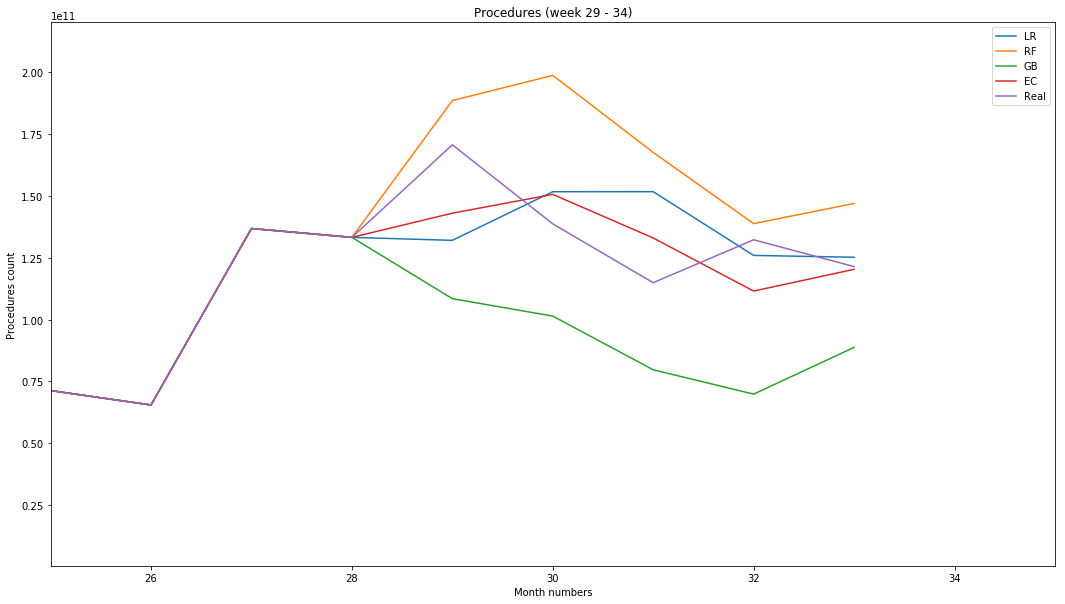

In [23]:
plt.plot(predict_ProcLR2)
plt.plot(predict_ProcRF2)
plt.plot(predict_ProcGB2)
plt.plot(predict_ProcEC2)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(600000000, 220000000000)

In [24]:
melt3 = melt.copy()
melt3['Last_Month_Proc'] = melt3.groupby(['RegCode'])['Proc'].shift()
melt3['Last_Month_Diff'] = melt3.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt3['Last-1_Month_Proc'] = melt3.groupby(['RegCode'])['Proc'].shift(2)
melt3['Last-1_Month_Diff'] = melt3.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt3 = melt3.dropna()
melt3.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff
729,11,4,1606575.1,0.0,0.0,0.0,0.0
972,11,5,0.0,1606575.1,1606575.1,0.0,0.0
1215,11,6,0.0,0.0,-1606575.1,1606575.1,1606575.1
1458,11,7,0.0,0.0,0.0,0.0,-1606575.1
1701,11,8,0.0,0.0,0.0,0.0,0.0


In [25]:
%%time
mean_errorLR3 = []
mean_errorRF3 = []
mean_errorGB3 = []

mean_errorEC3 = []


total_errorLR3 = []
predict_ProcLR3 = copy.copy(procedures)
abs_pr_errorLR3 = []

total_errorRF3 = []
predict_ProcRF3 = copy.copy(procedures)
abs_pr_errorRF3 = []

total_errorGB3 = []
predict_ProcGB3 = copy.copy(procedures)
abs_pr_errorGB3 = []

total_errorEC3 = []
predict_ProcEC3 = copy.copy(procedures)
abs_pr_errorEC3 = []
for Month in range(month_start, month_end):
    train = melt3[melt3['Month'] < Month]
    val = melt3[melt3['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR3 = rmsle(yts, plr)
    abs_errorLR3 = abs(total_yts-total_plr)
    abs_prLR3 = abs_errorLR3/total_yts*100
    
    mean_errorLR3.append(errorLR3)
    total_errorLR3.append(abs_errorLR3)
    predict_ProcLR3.append(total_plr)
    abs_pr_errorLR3.append(abs_prLR3)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF3 = rmsle(yts, prf)
    abs_errorRF3 = abs(total_yts-total_prf)
    abs_prRF3 = abs_errorRF3/total_yts*100
    
    mean_errorRF3.append(errorRF3)
    total_errorRF3.append(abs_errorRF3)
    predict_ProcRF3.append(total_prf)
    abs_pr_errorRF3.append(abs_prRF3)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB3 = rmsle(yts, pgb)
    abs_errorGB3 = abs(total_yts-total_pgb)
    abs_prGB3 = abs_errorGB3/total_yts*100
    
    mean_errorGB3.append(errorGB3)
    total_errorGB3.append(abs_errorGB3)
    predict_ProcGB3.append(total_pgb)
    abs_pr_errorGB3.append(abs_prGB3)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC3=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC3)

    errorEC3 = rmsle(yts, pEC3)
    abs_errorEC3 = abs(total_yts-total_pec)
    abs_prEC3 = abs_errorEC3/total_yts*100
    
    mean_errorEC3.append(errorEC3)
    total_errorEC3.append(abs_errorEC3)
    predict_ProcEC3.append(total_pec)
    abs_pr_errorEC3.append(abs_prEC3)
    print('Month %d' % (Month))
    print('LR3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR3, total_yts, total_plr, abs_errorLR3, abs_prLR3))
    print('RF3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF3, total_yts, total_prf, abs_errorRF3, abs_prRF3))
    print('GB3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB3, total_yts, total_pgb, abs_errorGB3, abs_prGB3))
    print('EC3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC3, total_yts, total_pec, abs_errorEC3, abs_prEC3))
print('Mean Error')
print('LR3 = %.5f, RF3 = %.5f, GB3 = %.5f, EC3 = %.5f' % (np.mean(mean_errorLR3), np.mean(mean_errorRF3), np.mean(mean_errorGB3), np.mean(mean_errorEC3)))
print('Mean Abs Error')
print('LR3 = %.1f, RF3 = %.1f, GB3 = %.1f, EC3 = %.1f' % (np.mean(total_errorLR3), np.mean(total_errorRF3), np.mean(total_errorGB3), np.mean(total_errorEC3)))
print('Mean Abs Error persent')
print('LR3 = %.1f, RF3 = %.1f, GB3 = %.1f, EC3 = %.1f' % (np.mean(abs_pr_errorLR3), np.mean(abs_pr_errorRF3), np.mean(abs_pr_errorGB3), np.mean(abs_pr_errorEC3)))

Month 29
LR3 - Error 5.08879, Real Total 170517288029.3 - Predict Total 120629851201.0, Abs Error 49887436828.3, Persent - 29.3
RF3 - Error 3.61782, Real Total 170517288029.3 - Predict Total 161045068239.3, Abs Error 9472219790.0, Persent - 5.6
GB3 - Error 2.14743, Real Total 170517288029.3 - Predict Total 106539947649.6, Abs Error 63977340379.7, Persent - 37.5
EC3 - Error 4.73501, Real Total 170517288029.3 - Predict Total 129404955696.6, Abs Error 41112332332.7, Persent - 24.1
Month 30
LR3 - Error 5.52233, Real Total 138610185794.3 - Predict Total 152787151579.8, Abs Error 14176965785.5, Persent - 10.2
RF3 - Error 3.72318, Real Total 138610185794.3 - Predict Total 201069897015.8, Abs Error 62459711221.5, Persent - 45.1
GB3 - Error 2.04077, Real Total 138610185794.3 - Predict Total 122332887297.8, Abs Error 16277298496.5, Persent - 11.7
EC3 - Error 5.16512, Real Total 138610185794.3 - Predict Total 158729978631.1, Abs Error 20119792836.8, Persent - 14.5
Month 31
LR3 - Error 5.45193, Re

(600000000, 220000000000)

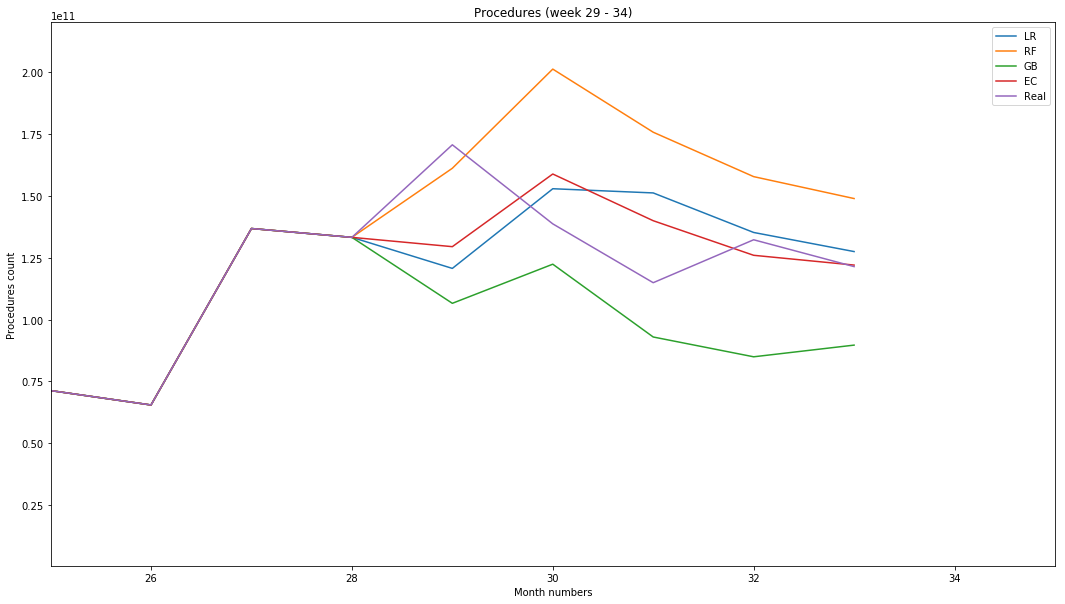

In [26]:
plt.plot(predict_ProcLR3)
plt.plot(predict_ProcRF3)
plt.plot(predict_ProcGB3)
plt.plot(predict_ProcEC3)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(600000000, 220000000000)

In [27]:
melt4 = melt.copy()
melt4['Last_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift()
melt4['Last_Month_Diff'] = melt4.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt4['Last-1_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift(2)
melt4['Last-1_Month_Diff'] = melt4.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt4['Last-2_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift(3)
melt4['Last-2_Month_Diff'] = melt4.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt4 = melt4.dropna()
melt4.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff,Last-2_Month_Proc,Last-2_Month_Diff
972,11,5,0.00,1606575.1,1606575.1,0.0,0.0,0.0,0.0
1215,11,6,0.00,0.0,-1606575.1,1606575.1,1606575.1,0.0,0.0
1458,11,7,0.00,0.0,0.0,0.0,-1606575.1,1606575.1,1606575.1
1701,11,8,0.00,0.0,0.0,0.0,0.0,0.0,-1606575.1
1944,11,9,566918.04,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
%%time
mean_errorLR4 = []
mean_errorRF4 = []
mean_errorGB4 = []

mean_errorEC4 = []


total_errorLR4 = []
predict_ProcLR4 = copy.copy(procedures)
abs_pr_errorLR4 = []

total_errorRF4 = []
predict_ProcRF4 = copy.copy(procedures)
abs_pr_errorRF4 = []

total_errorGB4 = []
predict_ProcGB4 = copy.copy(procedures)
abs_pr_errorGB4 = []

total_errorEC4 = []
predict_ProcEC4 = copy.copy(procedures)
abs_pr_errorEC4 = []
for Month in range(month_start, month_end):
    train = melt4[melt4['Month'] < Month]
    val = melt4[melt4['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR4 = rmsle(yts, plr)
    abs_errorLR4 = abs(total_yts-total_plr)
    abs_prLR4 = abs_errorLR4/total_yts*100
    
    mean_errorLR4.append(errorLR4)
    total_errorLR4.append(abs_errorLR4)
    predict_ProcLR4.append(total_plr)
    abs_pr_errorLR4.append(abs_prLR4)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF4 = rmsle(yts, prf)
    abs_errorRF4 = abs(total_yts-total_prf)
    abs_prRF4 = abs_errorRF4/total_yts*100
    
    mean_errorRF4.append(errorRF4)
    total_errorRF4.append(abs_errorRF4)
    predict_ProcRF4.append(total_prf)
    abs_pr_errorRF4.append(abs_prRF4)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB4 = rmsle(yts, pgb)
    abs_errorGB4 = abs(total_yts-total_pgb)
    abs_prGB4 = abs_errorGB4/total_yts*100
    
    mean_errorGB4.append(errorGB4)
    total_errorGB4.append(abs_errorGB4)
    predict_ProcGB4.append(total_pgb)
    abs_pr_errorGB4.append(abs_prGB4)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC4=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC4)

    errorEC4 = rmsle(yts, pEC4)
    abs_errorEC4 = abs(total_yts-total_pec)
    abs_prEC4 = abs_errorEC4/total_yts*100
    
    mean_errorEC4.append(errorEC4)
    total_errorEC4.append(abs_errorEC4)
    predict_ProcEC4.append(total_pec)
    abs_pr_errorEC4.append(abs_prEC4)
    print('Month %d' % (Month))
    print('LR4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR4, total_yts, total_plr, abs_errorLR4, abs_prLR4))
    print('RF4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF4, total_yts, total_prf, abs_errorRF4, abs_prRF4))
    print('GB4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB4, total_yts, total_pgb, abs_errorGB4, abs_prGB4))
    print('EC4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC4, total_yts, total_pec, abs_errorEC4, abs_prEC4))
print('Mean Error')
print('LR4 = %.5f, RF4 = %.5f, GB4 = %.5f, EC4 = %.5f' % (np.mean(mean_errorLR4), np.mean(mean_errorRF4), np.mean(mean_errorGB4), np.mean(mean_errorEC4)))
print('Mean Abs Error')
print('LR4 = %.1f, RF4 = %.1f, GB4 = %.1f, EC4 = %.1f' % (np.mean(total_errorLR4), np.mean(total_errorRF4), np.mean(total_errorGB4), np.mean(total_errorEC4)))
print('Mean Abs Error persent')
print('LR4 = %.1f, RF4 = %.1f, GB4 = %.1f, EC4 = %.1f' % (np.mean(abs_pr_errorLR4), np.mean(abs_pr_errorRF4), np.mean(abs_pr_errorGB4), np.mean(abs_pr_errorEC4)))

Month 29
LR4 - Error 4.95509, Real Total 170517288029.3 - Predict Total 109857036248.5, Abs Error 60660251780.8, Persent - 35.6
RF4 - Error 3.08570, Real Total 170517288029.3 - Predict Total 137008033282.8, Abs Error 33509254746.5, Persent - 19.7
GB4 - Error 2.08098, Real Total 170517288029.3 - Predict Total 89009177409.7, Abs Error 81508110619.6, Persent - 47.8
EC4 - Error 4.61578, Real Total 170517288029.3 - Predict Total 111958082313.7, Abs Error 58559205715.6, Persent - 34.3
Month 30
LR4 - Error 5.48059, Real Total 138610185794.3 - Predict Total 136167796614.6, Abs Error 2442389179.7, Persent - 1.8
RF4 - Error 3.58754, Real Total 138610185794.3 - Predict Total 185147254801.7, Abs Error 46537069007.4, Persent - 33.6
GB4 - Error 2.05058, Real Total 138610185794.3 - Predict Total 117256974652.1, Abs Error 21353211142.2, Persent - 15.4
EC4 - Error 5.12831, Real Total 138610185794.3 - Predict Total 146190675356.1, Abs Error 7580489561.8, Persent - 5.5
Month 31
LR4 - Error 5.37620, Real 

(600000000, 220000000000)

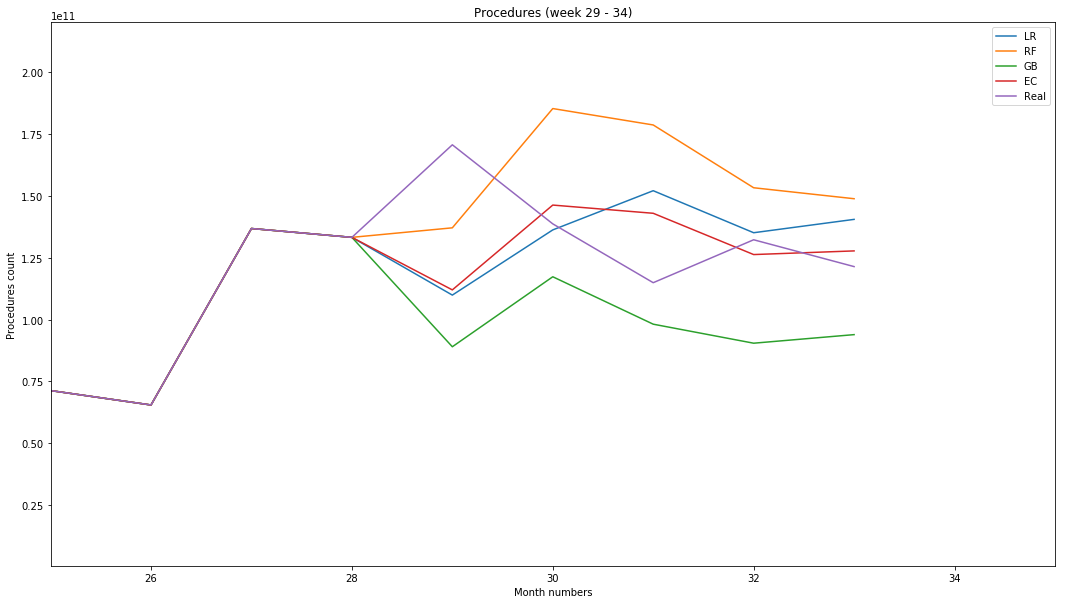

In [29]:
plt.plot(predict_ProcLR4)
plt.plot(predict_ProcRF4)
plt.plot(predict_ProcGB4)
plt.plot(predict_ProcEC4)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(600000000, 220000000000)

In [30]:
%%time
mean_errorRF4_n = []
total_errorRF4_n = []
ProcRF4_n = copy.copy(procedures)
predict_ProcRF4_n = copy.copy(procedures)
abs_pr_errorRF4_n = []
for month in range(month_start, month_end):
    train = melt4[melt4['Month'] < month]
    val = melt4[melt4['Month'] == month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorRF4_n.append(error)
    total_errorRF4_n.append(abs_error)
    ProcRF4_n.append(total_yts)
    predict_ProcRF4_n.append(total_p)
    abs_pr_errorRF4_n.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorRF4_n))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF4_n))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF4_n))

Month 29 - Error 2.48644, Real Total 170517288029.3 - Predict Total 69407707061.6, Abs Error 101109580967.7, Persent - 59.3
Month 30 - Error 2.17376, Real Total 138610185794.3 - Predict Total 94506491819.6, Abs Error 44103693974.7, Persent - 31.8
Month 31 - Error 2.40586, Real Total 114863526233.8 - Predict Total 98868885470.2, Abs Error 15994640763.6, Persent - 13.9
Month 32 - Error 2.72894, Real Total 132186973999.4 - Predict Total 89424012920.7, Abs Error 42762961078.6, Persent - 32.4
Month 33 - Error 2.49489, Real Total 121359958523.1 - Predict Total 91028957923.2, Abs Error 30331000599.9, Persent - 25.0
Mean Error = 2.45798
Mean Abs Error = 46860375476.89944
Mean Abs Error persent = 32.47643
Wall time: 1min 48s


In [31]:
%%time
melt12 = melt.copy()
melt12['Last_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift()
melt12['Last_Month_Diff'] = melt12.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt12['Last-1_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(2)
melt12['Last-1_Month_Diff'] = melt12.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt12['Last-2_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-2_Month_Diff'] = melt12.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt12['Last-3_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-3_Month_Diff'] = melt12.groupby(['RegCode'])['Last-3_Month_Proc'].diff()
melt12['Last-4_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-4_Month_Diff'] = melt12.groupby(['RegCode'])['Last-4_Month_Proc'].diff()
melt12['Last-5_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-5_Month_Diff'] = melt12.groupby(['RegCode'])['Last-5_Month_Proc'].diff()
melt12['Last-6_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-6_Month_Diff'] = melt12.groupby(['RegCode'])['Last-6_Month_Proc'].diff()
melt12['Last-7_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-7_Month_Diff'] = melt12.groupby(['RegCode'])['Last-7_Month_Proc'].diff()
melt12['Last-8_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-8_Month_Diff'] = melt12.groupby(['RegCode'])['Last-8_Month_Proc'].diff()
melt12['Last-9_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-9_Month_Diff'] = melt12.groupby(['RegCode'])['Last-9_Month_Proc'].diff()
melt12['Last-10_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-10_Month_Diff'] = melt12.groupby(['RegCode'])['Last-10_Month_Proc'].diff()
melt12['Last-11_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(2)
melt12['Last-11_Month_Diff'] = melt12.groupby(['RegCode'])['Last-11_Month_Proc'].diff()
melt12['Last-12_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-12_Month_Diff'] = melt12.groupby(['RegCode'])['Last-12_Month_Proc'].diff()
melt12 = melt12.dropna()
melt12.head()

Wall time: 648 ms


In [32]:
%%time
mean_errorLR12 = []
mean_errorRF12 = []
mean_errorGB12 = []

mean_errorEC12 = []


total_errorLR12 = []
predict_ProcLR12 = copy.copy(procedures)
abs_pr_errorLR12 = []

total_errorRF12 = []
predict_ProcRF12 = copy.copy(procedures)
abs_pr_errorRF12 = []

total_errorGB12 = []
predict_ProcGB12 = copy.copy(procedures)
abs_pr_errorGB12 = []

total_errorEC12 = []
predict_ProcEC12 = copy.copy(procedures)
abs_pr_errorEC12 = []
for Month in range(month_start, month_end):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR12 = rmsle(yts, plr)
    abs_errorLR12 = abs(total_yts-total_plr)
    abs_prLR12 = abs_errorLR12/total_yts*100
    
    mean_errorLR12.append(errorLR12)
    total_errorLR12.append(abs_errorLR12)
    predict_ProcLR12.append(total_plr)
    abs_pr_errorLR12.append(abs_prLR12)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF12 = rmsle(yts, prf)
    abs_errorRF12 = abs(total_yts-total_prf)
    abs_prRF12 = abs_errorRF12/total_yts*100
    
    mean_errorRF12.append(errorRF12)
    total_errorRF12.append(abs_errorRF12)
    predict_ProcRF12.append(total_prf)
    abs_pr_errorRF12.append(abs_prRF12)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB12 = rmsle(yts, pgb)
    abs_errorGB12 = abs(total_yts-total_pgb)
    abs_prGB12 = abs_errorGB12/total_yts*100
    
    mean_errorGB12.append(errorGB12)
    total_errorGB12.append(abs_errorGB12)
    predict_ProcGB12.append(total_pgb)
    abs_pr_errorGB12.append(abs_prGB12)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC12=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC12)

    errorEC12 = rmsle(yts, pEC12)
    abs_errorEC12 = abs(total_yts-total_pec)
    abs_prEC12 = abs_errorEC12/total_yts*100
    
    mean_errorEC12.append(errorEC12)
    total_errorEC12.append(abs_errorEC12)
    predict_ProcEC12.append(total_pec)
    abs_pr_errorEC12.append(abs_prEC12)
    print('Month %d' % (Month))
    print('LR12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR12, total_yts, total_plr, abs_errorLR12, abs_prLR12))
    print('RF12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF12, total_yts, total_prf, abs_errorRF12, abs_prRF12))
    print('GB12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB12, total_yts, total_pgb, abs_errorGB12, abs_prGB12))
    print('EC12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC12, total_yts, total_pec, abs_errorEC12, abs_prEC12))
print('Mean Error')
print('LR12 = %.5f, RF12 = %.5f, GB12 = %.5f, EC12 = %.5f' % (np.mean(mean_errorLR12), np.mean(mean_errorRF12), np.mean(mean_errorGB12), np.mean(mean_errorEC12)))
print('Mean Abs Error')
print('LR12 = %.1f, RF12 = %.1f, GB12 = %.1f, EC12 = %.1f' % (np.mean(total_errorLR12), np.mean(total_errorRF12), np.mean(total_errorGB12), np.mean(total_errorEC12)))
print('Mean Abs Error persent')
print('LR12 = %.1f, RF12 = %.1f, GB12 = %.1f, EC12 = %.1f' % (np.mean(abs_pr_errorLR12), np.mean(abs_pr_errorRF12), np.mean(abs_pr_errorGB12), np.mean(abs_pr_errorEC12)))

Month 29
LR12 - Error 4.91828, Real Total 170517288029.3 - Predict Total 109325987276.4, Abs Error 61191300752.9, Persent - 35.9
RF12 - Error 3.08592, Real Total 170517288029.3 - Predict Total 136312744569.1, Abs Error 34204543460.2, Persent - 20.1
GB12 - Error 2.08098, Real Total 170517288029.3 - Predict Total 89009177409.7, Abs Error 81508110619.6, Persent - 47.8
EC12 - Error 4.58459, Real Total 170517288029.3 - Predict Total 111549303085.1, Abs Error 58967984944.2, Persent - 34.6
Month 30
LR12 - Error 5.47433, Real Total 138610185794.3 - Predict Total 135832538174.6, Abs Error 2777647619.7, Persent - 2.0
RF12 - Error 3.60133, Real Total 138610185794.3 - Predict Total 183337972899.3, Abs Error 44727787105.0, Persent - 32.3
GB12 - Error 2.05058, Real Total 138610185794.3 - Predict Total 117256974652.1, Abs Error 21353211142.2, Persent - 15.4
EC12 - Error 5.12254, Real Total 138610185794.3 - Predict Total 145475828575.3, Abs Error 6865642781.0, Persent - 5.0
Month 31
LR12 - Error 5.345

(600000000, 220000000000)

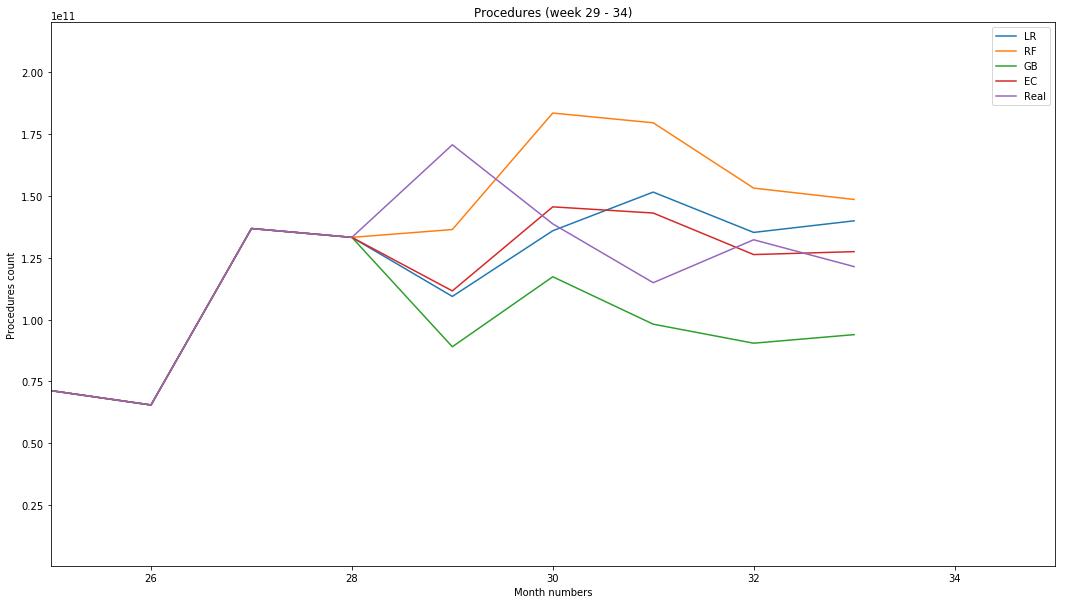

In [33]:
plt.plot(predict_ProcLR12)
plt.plot(predict_ProcRF12)
plt.plot(predict_ProcGB12)
plt.plot(predict_ProcEC12)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(600000000, 220000000000)

C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


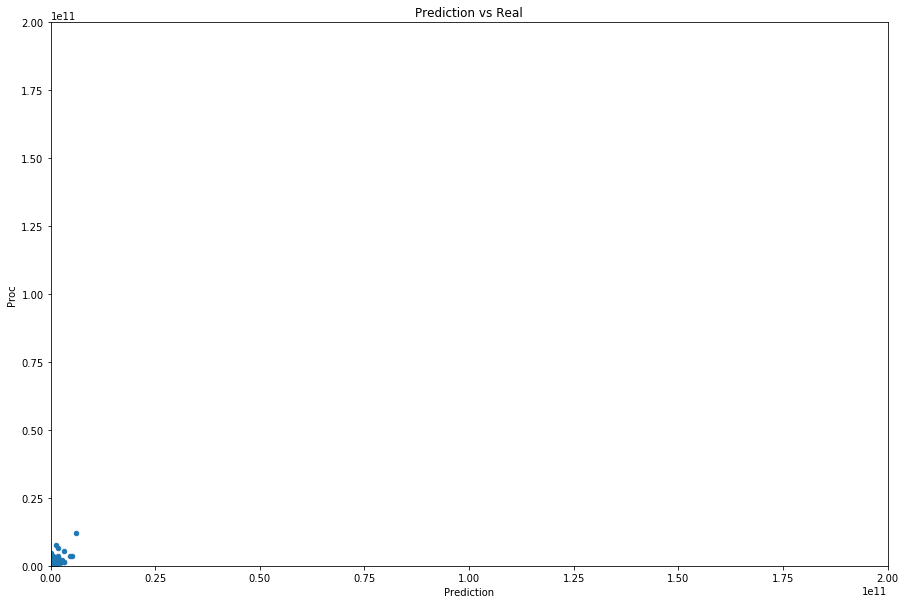

In [34]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Proc', figsize=(15,10), title='Prediction vs Real', 
                 ylim=(0,200000000000), xlim=(0,200000000000))

In [35]:
%%time
melt24 = melt.copy()
melt24['Last_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift()
melt24['Last_Month_Diff'] = melt24.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt24['Last-1_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-1_Month_Diff'] = melt24.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt24['Last-2_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-2_Month_Diff'] = melt24.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt24['Last-3_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-3_Month_Diff'] = melt24.groupby(['RegCode'])['Last-3_Month_Proc'].diff()
melt24['Last-4_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-4_Month_Diff'] = melt24.groupby(['RegCode'])['Last-4_Month_Proc'].diff()
melt24['Last-5_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-5_Month_Diff'] = melt24.groupby(['RegCode'])['Last-5_Month_Proc'].diff()
melt24['Last-6_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-6_Month_Diff'] = melt24.groupby(['RegCode'])['Last-6_Month_Proc'].diff()
melt24['Last-7_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-7_Month_Diff'] = melt24.groupby(['RegCode'])['Last-7_Month_Proc'].diff()
melt24['Last-8_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-8_Month_Diff'] = melt24.groupby(['RegCode'])['Last-8_Month_Proc'].diff()
melt24['Last-9_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-9_Month_Diff'] = melt24.groupby(['RegCode'])['Last-9_Month_Proc'].diff()
melt24['Last-10_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-10_Month_Diff'] = melt24.groupby(['RegCode'])['Last-10_Month_Proc'].diff()
melt24['Last-11_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-11_Month_Diff'] = melt24.groupby(['RegCode'])['Last-11_Month_Proc'].diff()
melt24['Last-12_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-12_Month_Diff'] = melt24.groupby(['RegCode'])['Last-12_Month_Proc'].diff()
melt24['Last-13_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-13_Month_Diff'] = melt24.groupby(['RegCode'])['Last-13_Month_Proc'].diff()
melt24['Last-14_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-14_Month_Diff'] = melt24.groupby(['RegCode'])['Last-14_Month_Proc'].diff()
melt24['Last-15_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-15_Month_Diff'] = melt24.groupby(['RegCode'])['Last-15_Month_Proc'].diff()
melt24['Last-16_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-16_Month_Diff'] = melt24.groupby(['RegCode'])['Last-16_Month_Proc'].diff()
melt24['Last-17_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-17_Month_Diff'] = melt24.groupby(['RegCode'])['Last-17_Month_Proc'].diff()
melt24['Last-18_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-18_Month_Diff'] = melt24.groupby(['RegCode'])['Last-18_Month_Proc'].diff()
melt24['Last-19_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-19_Month_Diff'] = melt24.groupby(['RegCode'])['Last-19_Month_Proc'].diff()
melt24['Last-20_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-20_Month_Diff'] = melt24.groupby(['RegCode'])['Last-20_Month_Proc'].diff()
melt24['Last-21_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-21_Month_Diff'] = melt24.groupby(['RegCode'])['Last-21_Month_Proc'].diff()
melt24['Last-22_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-22_Month_Diff'] = melt24.groupby(['RegCode'])['Last-22_Month_Proc'].diff()
melt24['Last-23_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-23_Month_Diff'] = melt24.groupby(['RegCode'])['Last-23_Month_Proc'].diff()
melt24['Last-24_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-24_Month_Diff'] = melt24.groupby(['RegCode'])['Last-24_Month_Proc'].diff()
melt24 = melt24.dropna()
melt24.head()

Wall time: 1.1 s


In [36]:
%%time
mean_errorLR24 = []
mean_errorRF24 = []
mean_errorGB24 = []

mean_errorEC24 = []


total_errorLR24 = []
predict_ProcLR24 = copy.copy(procedures)
abs_pr_errorLR24 = []

total_errorRF24 = []
predict_ProcRF24 = copy.copy(procedures)
abs_pr_errorRF24 = []

total_errorGB24 = []
predict_ProcGB24 = copy.copy(procedures)
abs_pr_errorGB24 = []

total_errorEC24 = []
predict_ProcEC24 = copy.copy(procedures)
abs_pr_errorEC24 = []
for Month in range(month_start, month_end):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR24 = rmsle(yts, plr)
    abs_errorLR24 = abs(total_yts-total_plr)
    abs_prLR24 = abs_errorLR24/total_yts*100
    
    mean_errorLR24.append(errorLR24)
    total_errorLR24.append(abs_errorLR24)
    predict_ProcLR24.append(total_plr)
    abs_pr_errorLR24.append(abs_prLR24)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF24 = rmsle(yts, prf)
    abs_errorRF24 = abs(total_yts-total_prf)
    abs_prRF24 = abs_errorRF24/total_yts*100
    
    mean_errorRF24.append(errorRF24)
    total_errorRF24.append(abs_errorRF24)
    predict_ProcRF24.append(total_prf)
    abs_pr_errorRF24.append(abs_prRF24)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB24 = rmsle(yts, pgb)
    abs_errorGB24 = abs(total_yts-total_pgb)
    abs_prGB24 = abs_errorGB24/total_yts*100
    
    mean_errorGB24.append(errorGB24)
    total_errorGB24.append(abs_errorGB24)
    predict_ProcGB24.append(total_pgb)
    abs_pr_errorGB24.append(abs_prGB24)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC24=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC24)

    errorEC24 = rmsle(yts, pEC24)
    abs_errorEC24 = abs(total_yts-total_pec)
    abs_prEC24 = abs_errorEC24/total_yts*100
    
    mean_errorEC24.append(errorEC24)
    total_errorEC24.append(abs_errorEC24)
    predict_ProcEC24.append(total_pec)
    abs_pr_errorEC24.append(abs_prEC24)
    print('Month %d' % (Month))
    print('LR24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR24, total_yts, total_plr, abs_errorLR24, abs_prLR24))
    print('RF24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF24, total_yts, total_prf, abs_errorRF24, abs_prRF24))
    print('GB24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB24, total_yts, total_pgb, abs_errorGB24, abs_prGB24))
    print('EC24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC24, total_yts, total_pec, abs_errorEC24, abs_prEC24))
print('Mean Error')
print('LR24 = %.5f, RF24 = %.5f, GB24 = %.5f, EC24 = %.5f' % (np.mean(mean_errorLR24), np.mean(mean_errorRF24), np.mean(mean_errorGB24), np.mean(mean_errorEC24)))
print('Mean Abs Error')
print('LR24 = %.1f, RF24 = %.1f, GB24 = %.1f, EC24 = %.1f' % (np.mean(total_errorLR24), np.mean(total_errorRF24), np.mean(total_errorGB24), np.mean(total_errorEC24)))
print('Mean Abs Error persent')
print('LR24 = %.1f, RF24 = %.1f, GB24 = %.1f, EC24 = %.1f' % (np.mean(abs_pr_errorLR24), np.mean(abs_pr_errorRF24), np.mean(abs_pr_errorGB24), np.mean(abs_pr_errorEC24)))

Month 29
LR24 - Error 4.93485, Real Total 170517288029.3 - Predict Total 114494057765.2, Abs Error 56023230264.1, Persent - 32.9
RF24 - Error 3.11960, Real Total 170517288029.3 - Predict Total 136195459268.8, Abs Error 34321828760.5, Persent - 20.1
GB24 - Error 2.08098, Real Total 170517288029.3 - Predict Total 89009177409.7, Abs Error 81508110619.6, Persent - 47.8
EC24 - Error 4.59830, Real Total 170517288029.3 - Predict Total 113232898147.9, Abs Error 57284389881.4, Persent - 33.6
Month 30
LR24 - Error 5.49074, Real Total 138610185794.3 - Predict Total 135856509310.4, Abs Error 2753676483.9, Persent - 2.0
RF24 - Error 3.60240, Real Total 138610185794.3 - Predict Total 183291789623.8, Abs Error 44681603829.5, Persent - 32.2
GB24 - Error 2.05058, Real Total 138610185794.3 - Predict Total 117256974652.1, Abs Error 21353211142.2, Persent - 15.4
EC24 - Error 5.13641, Real Total 138610185794.3 - Predict Total 145468424528.8, Abs Error 6858238734.5, Persent - 4.9
Month 31
LR24 - Error 5.384

(600000000, 220000000000)

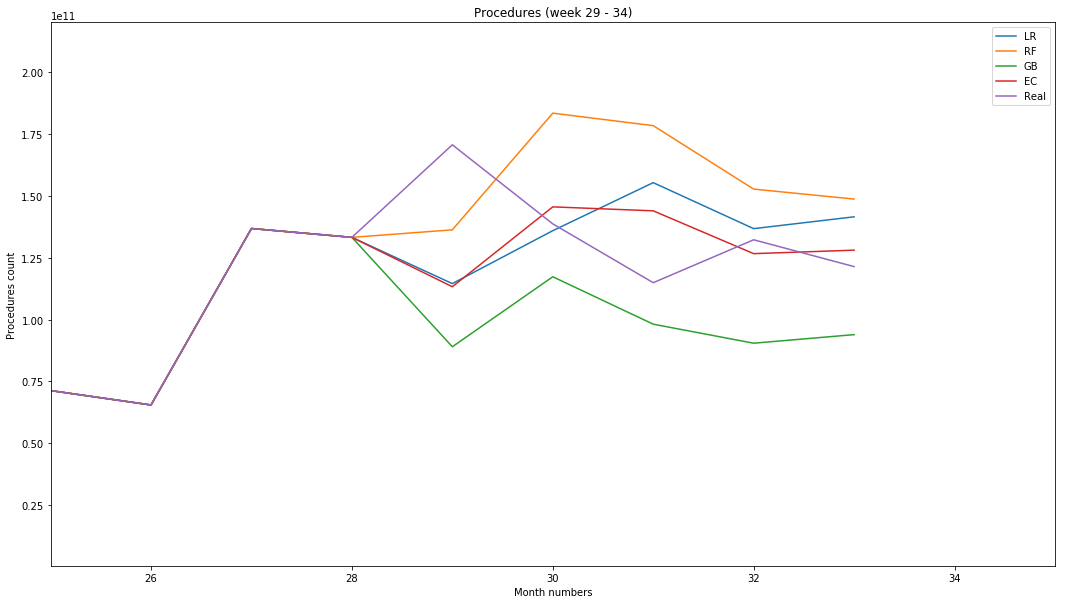

In [37]:
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(predict_ProcEC24)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(600000000, 220000000000)

(600000000, 220000000000)

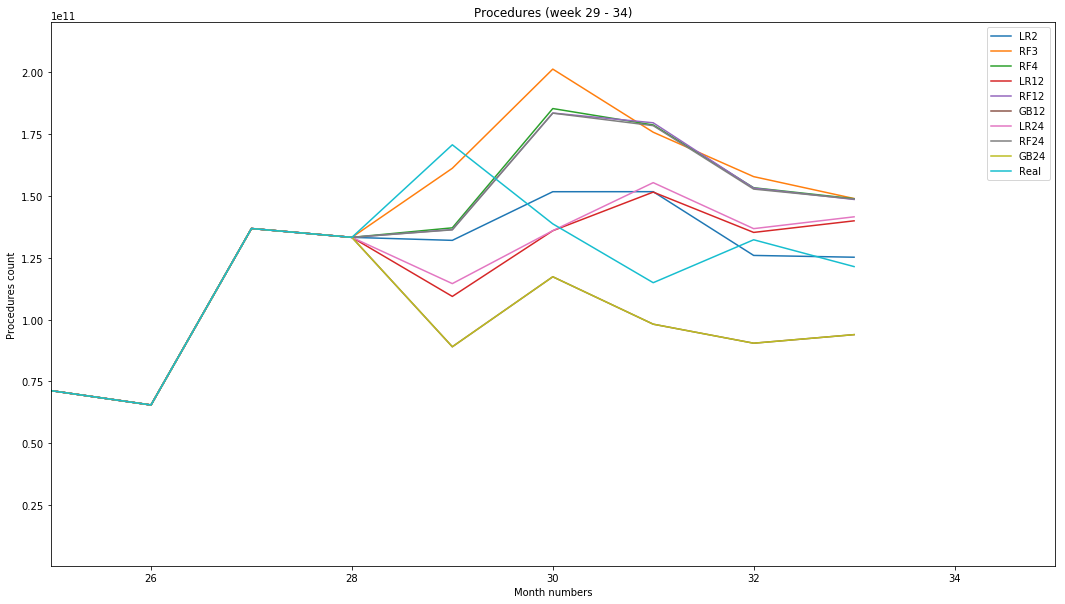

In [38]:
plt.plot(predict_ProcLR2)
plt.plot(predict_ProcRF3)
plt.plot(predict_ProcRF4)
plt.plot(predict_ProcLR12)
plt.plot(predict_ProcRF12)
plt.plot(predict_ProcGB12)
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(proceduresAll)

plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR2', 'RF3', 'RF4', 'LR12', 'RF12', 'GB12', 'LR24', 'RF24', 'GB24', 'Real'))
plt.xlim(25, 35)
plt.ylim(600000000, 220000000000)

In [39]:
print('Mean Error baseline = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error baseline = %.5f' % np.mean(total_errorB))
print('Mean Abs Error baseline persent = %.5f' % np.mean(abs_pr_errorB))
print('Mean Error LR2 = %.5f' % np.mean(mean_errorLR2))
print('Mean Abs Error LR2 = %.5f' % np.mean(total_errorLR2))
print('Mean Abs Error LR2 persent = %.5f' % np.mean(abs_pr_errorLR2))
print('Mean Error RF2 = %.5f' % np.mean(mean_errorRF2))
print('Mean Abs Error RF2 = %.5f' % np.mean(total_errorRF2))
print('Mean Abs Error RF2 persent = %.5f' % np.mean(abs_pr_errorRF2))
print('Mean Error RF3 = %.5f' % np.mean(mean_errorRF3))
print('Mean Abs Error RF3 = %.5f' % np.mean(total_errorRF3))
print('Mean Abs Error RF3 persent = %.5f' % np.mean(abs_pr_errorRF3))
print('Mean Error RF4 = %.5f' % np.mean(mean_errorRF4))
print('Mean Abs Error RF4 = %.5f' % np.mean(total_errorRF4))
print('Mean Abs Error RF4 persent = %.5f' % np.mean(abs_pr_errorRF4))
print('Mean Error RF4_n = %.5f' % np.mean(mean_errorRF4_n))
print('Mean Abs Error RF4_n = %.5f' % np.mean(total_errorRF4_n))
print('Mean Abs Error RF4_n persent = %.5f' % np.mean(abs_pr_errorRF4_n))
print('Mean Error GB4 = %.5f' % np.mean(mean_errorGB4))
print('Mean Abs Error GB4 = %.5f' % np.mean(total_errorGB4))
print('Mean Abs Error GB4 persent = %.5f' % np.mean(abs_pr_errorGB4))
print('Mean Error LR12 = %.5f' % np.mean(mean_errorLR12))
print('Mean Abs Error LR12 = %.5f' % np.mean(total_errorLR12))
print('Mean Abs Error LR12 persent = %.5f' % np.mean(abs_pr_errorLR12))
print('Mean Error = %.5f' % np.mean(mean_errorRF12))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF12))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF12))
print('Mean Error GB12 = %.5f' % np.mean(mean_errorGB12))
print('Mean Abs Error GB12 = %.5f' % np.mean(total_errorGB12))
print('Mean Abs Error GB12 persent = %.5f' % np.mean(abs_pr_errorGB12))
print('Mean Error LR24 = %.5f' % np.mean(mean_errorLR24))
print('Mean Abs Error LR24 = %.5f' % np.mean(total_errorLR24))
print('Mean Abs Error LR24 persent = %.5f' % np.mean(abs_pr_errorLR24))
print('Mean Error = %.5f' % np.mean(mean_errorRF24))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF24))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF24))
print('Mean Error GB24 = %.5f' % np.mean(mean_errorGB24))
print('Mean Abs Error GB24 = %.5f' % np.mean(total_errorGB24))
print('Mean Abs Error GB24 persent = %.5f' % np.mean(abs_pr_errorGB24))

Mean Error baseline = 2.49364
Mean Abs Error baseline = 24232314476.90397
Mean Abs Error baseline persent = 17.52560
Mean Error LR2 = 5.55996
Mean Abs Error LR2 = 19675298612.71810
Mean Abs Error LR2 persent = 14.37115
Mean Error RF2 = 3.83724
Mean Abs Error RF2 = 32472681059.81586
Mean Abs Error RF2 persent = 25.08234
Mean Error RF3 = 3.86382
Mean Abs Error RF3 = 37123517043.35680
Mean Abs Error RF3 persent = 29.08062
Mean Error RF4 = 3.69868
Mean Abs Error RF4 = 38419582584.87740
Mean Abs Error RF4 persent = 29.42107
Mean Error RF4_n = 2.45798
Mean Abs Error RF4_n = 46860375476.89944
Mean Abs Error RF4_n persent = 32.47643
Mean Error GB4 = 2.33968
Mean Abs Error GB4 = 37762206422.48088
Mean Abs Error GB4 persent = 26.39816
Mean Error LR12 = 5.37185
Mean Abs Error LR12 = 24394117555.95405
Mean Abs Error LR12 persent = 17.43728
Mean Error = 3.68519
Mean Abs Error = 38283226309.95789
Mean Abs Error persent = 29.32283
Mean Error GB12 = 2.33968
Mean Abs Error GB12 = 37762206422.48088
Mean

In [40]:
cols = ['RegCode', 'Month', 'Last_Month_Proc', 'Last_Month_Diff',
       'Last-1_Month_Proc', 'Last-1_Month_Diff', 'Last-2_Month_Proc',
       'Last-2_Month_Diff', 'Last-3_Month_Proc', 'Last-3_Month_Diff',
       'Last-4_Month_Proc', 'Last-4_Month_Diff', 'Last-5_Month_Proc',
       'Last-5_Month_Diff', 'Last-6_Month_Proc', 'Last-6_Month_Diff',
       'Last-7_Month_Proc', 'Last-7_Month_Diff', 'Last-8_Month_Proc',
       'Last-8_Month_Diff', 'Last-9_Month_Proc', 'Last-9_Month_Diff',
       'Last-10_Month_Proc', 'Last-10_Month_Diff', 'Last-11_Month_Proc',
       'Last-11_Month_Diff', 'Last-12_Month_Proc', 'Last-12_Month_Diff',
       'Last-13_Month_Proc', 'Last-13_Month_Diff', 'Last-14_Month_Proc',
       'Last-14_Month_Diff', 'Last-15_Month_Proc', 'Last-15_Month_Diff',
       'Last-16_Month_Proc', 'Last-16_Month_Diff', 'Last-17_Month_Proc',
       'Last-17_Month_Diff', 'Last-18_Month_Proc', 'Last-18_Month_Diff',
       'Last-19_Month_Proc', 'Last-19_Month_Diff', 'Last-20_Month_Proc',
       'Last-20_Month_Diff', 'Last-21_Month_Proc', 'Last-21_Month_Diff',
       'Last-22_Month_Proc', 'Last-22_Month_Diff', 'Last-23_Month_Proc',
       'Last-23_Month_Diff', 'Last-24_Month_Proc', 'Last-24_Month_Diff']

In [41]:
%%time
#Заготовка под массив столбцов
c = []
colMeanError =[]
#Переменная под максимальное значение score
minErrorValue=100
colMeanAbsError =[]
bestPredictPorc_er = []
minAbsErrorValue=100
minAbsError=250000000000
bestPredictPorc_AbsEr = []
  
#Запоминаем длинну выборки столбцов - 1 (последний столбец - целевая переменная)
l=len(cols) - 1
#В трех циклах последовательно проходим по столбцам и формируем тройки, для каждой трокий делаем get_dummies для 
#перечислимых переменных, строим модель и вычисляем score.
#В переменных maxValue и bestParams сохраняем значения лучщего score и набор параметров, для которого он получился
bestCols = []
for i in range(0, l, 1):
    for j in range(i+1, l, 1):
        #Проверяем, что у нас нет одинаковых столбцов в выборке
        if cols[i]==cols[j]:
            continue
        c = []
        #Добавляем названия столбцов в выборку    
        c.append(cols[i])
        c.append(cols[j])
        mean_error = []
        total_error = []
        Proc = copy.copy(procedures)
        predict_Proc = copy.copy(procedures)
        abs_pr_error = []
        for Month in range(month_start, month_end):
            train = melt24[melt24['Month'] < Month]
            val = melt24[melt24['Month'] == Month]
            
            #Выделяем столбцы для эксперимента
            xtr, xts = train[c].values, val[c].values
            ytr, yts = train['Proc'].values, val['Proc'].values
                
            mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
            mdl.fit(xtr, ytr)
    
            p = mdl.predict(xts)
    
            total_yts=sum(yts)
            total_p=sum(p)
                
            error = rmsle(yts, p)
            abs_error = abs(total_yts-total_p)
            abs_pr = abs_error/total_yts*100

            #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
            mean_error.append(error)
            total_error.append(abs_error)
            Proc.append(total_yts)
            predict_Proc.append(total_p)
            abs_pr_error.append(abs_pr)
        MR = np.mean(mean_error)
        TR = np.mean(total_error)
        TRP = np.mean(abs_pr_error)
        print(c)
        print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
        if MR<minErrorValue:
            minErrorValue=MR
            colMeanError=c
            bestPredictPorc_er = predict_Proc
        if TRP<minAbsErrorValue:
            minAbsErrorValue=TRP
            colMeanAbsError=c
            bestPredictPorc_AbsEr = predict_Proc
        if TR<minAbsError:
            minAbsError=TR
            bestCols=c
            bestPredictPorc_AbsEr = predict_Proc
                

['RegCode', 'Month']
Mean Error 4.26939, Abs Error 25551244946.6, Abs Error Persent - 18.7
['RegCode', 'Last_Month_Proc']
Mean Error 3.84619, Abs Error 13467932581.4, Abs Error Persent - 10.4
['RegCode', 'Last_Month_Diff']
Mean Error 4.02609, Abs Error 21150122388.7, Abs Error Persent - 14.3
['RegCode', 'Last-1_Month_Proc']
Mean Error 3.94418, Abs Error 20778362421.5, Abs Error Persent - 15.0
['RegCode', 'Last-1_Month_Diff']
Mean Error 4.23129, Abs Error 22882528024.6, Abs Error Persent - 15.5
['RegCode', 'Last-2_Month_Proc']
Mean Error 4.01207, Abs Error 18386991525.3, Abs Error Persent - 12.0
['RegCode', 'Last-2_Month_Diff']
Mean Error 4.23424, Abs Error 16646610341.5, Abs Error Persent - 11.1
['RegCode', 'Last-3_Month_Proc']
Mean Error 4.01207, Abs Error 18386991525.3, Abs Error Persent - 12.0
['RegCode', 'Last-3_Month_Diff']
Mean Error 4.23424, Abs Error 16646610341.5, Abs Error Persent - 11.1
['RegCode', 'Last-4_Month_Proc']
Mean Error 4.01207, Abs Error 18386991525.3, Abs Error P

['Month', 'Last-15_Month_Proc']
Mean Error 4.73619, Abs Error 51121191542.1, Abs Error Persent - 37.0
['Month', 'Last-15_Month_Diff']
Mean Error 4.80555, Abs Error 40561808477.0, Abs Error Persent - 31.3
['Month', 'Last-16_Month_Proc']
Mean Error 4.73619, Abs Error 51121191542.1, Abs Error Persent - 37.0
['Month', 'Last-16_Month_Diff']
Mean Error 4.80555, Abs Error 40561808477.0, Abs Error Persent - 31.3
['Month', 'Last-17_Month_Proc']
Mean Error 4.73619, Abs Error 51121191542.1, Abs Error Persent - 37.0
['Month', 'Last-17_Month_Diff']
Mean Error 4.80555, Abs Error 40561808477.0, Abs Error Persent - 31.3
['Month', 'Last-18_Month_Proc']
Mean Error 4.73619, Abs Error 51121191542.1, Abs Error Persent - 37.0
['Month', 'Last-18_Month_Diff']
Mean Error 4.80555, Abs Error 40561808477.0, Abs Error Persent - 31.3
['Month', 'Last-19_Month_Proc']
Mean Error 4.73619, Abs Error 51121191542.1, Abs Error Persent - 37.0
['Month', 'Last-19_Month_Diff']
Mean Error 4.80555, Abs Error 40561808477.0, Abs E

['Last_Month_Diff', 'Last-5_Month_Diff']
Mean Error 4.38891, Abs Error 20943650736.6, Abs Error Persent - 14.4
['Last_Month_Diff', 'Last-6_Month_Proc']
Mean Error 4.38288, Abs Error 27344800896.8, Abs Error Persent - 18.5
['Last_Month_Diff', 'Last-6_Month_Diff']
Mean Error 4.38891, Abs Error 20943650736.6, Abs Error Persent - 14.4
['Last_Month_Diff', 'Last-7_Month_Proc']
Mean Error 4.38288, Abs Error 27344800896.8, Abs Error Persent - 18.5
['Last_Month_Diff', 'Last-7_Month_Diff']
Mean Error 4.38891, Abs Error 20943650736.6, Abs Error Persent - 14.4
['Last_Month_Diff', 'Last-8_Month_Proc']
Mean Error 4.38288, Abs Error 27344800896.8, Abs Error Persent - 18.5
['Last_Month_Diff', 'Last-8_Month_Diff']
Mean Error 4.38891, Abs Error 20943650736.6, Abs Error Persent - 14.4
['Last_Month_Diff', 'Last-9_Month_Proc']
Mean Error 4.38288, Abs Error 27344800896.8, Abs Error Persent - 18.5
['Last_Month_Diff', 'Last-9_Month_Diff']
Mean Error 4.38891, Abs Error 20943650736.6, Abs Error Persent - 14.4
[

['Last-1_Month_Proc', 'Last-19_Month_Proc']
Mean Error 4.64239, Abs Error 32924637005.7, Abs Error Persent - 23.9
['Last-1_Month_Proc', 'Last-19_Month_Diff']
Mean Error 4.41987, Abs Error 25496799351.7, Abs Error Persent - 18.8
['Last-1_Month_Proc', 'Last-20_Month_Proc']
Mean Error 4.64239, Abs Error 32924637005.7, Abs Error Persent - 23.9
['Last-1_Month_Proc', 'Last-20_Month_Diff']
Mean Error 4.41987, Abs Error 25496799351.7, Abs Error Persent - 18.8
['Last-1_Month_Proc', 'Last-21_Month_Proc']
Mean Error 4.77124, Abs Error 19910196352.4, Abs Error Persent - 14.6
['Last-1_Month_Proc', 'Last-21_Month_Diff']
Mean Error 4.61213, Abs Error 31814879378.8, Abs Error Persent - 23.0
['Last-1_Month_Proc', 'Last-22_Month_Proc']
Mean Error 4.64239, Abs Error 32924637005.7, Abs Error Persent - 23.9
['Last-1_Month_Proc', 'Last-22_Month_Diff']
Mean Error 4.41987, Abs Error 25496799351.7, Abs Error Persent - 18.8
['Last-1_Month_Proc', 'Last-23_Month_Proc']
Mean Error 4.64239, Abs Error 32924637005.7,

['Last-2_Month_Proc', 'Last-11_Month_Proc']
Mean Error 4.64239, Abs Error 32924637005.7, Abs Error Persent - 23.9
['Last-2_Month_Proc', 'Last-11_Month_Diff']
Mean Error 4.64299, Abs Error 33307296737.6, Abs Error Persent - 24.5
['Last-2_Month_Proc', 'Last-12_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-2_Month_Proc', 'Last-12_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-2_Month_Proc', 'Last-13_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-2_Month_Proc', 'Last-13_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-2_Month_Proc', 'Last-14_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-2_Month_Proc', 'Last-14_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-2_Month_Proc', 'Last-15_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9,

['Last-3_Month_Proc', 'Last-5_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-3_Month_Proc', 'Last-5_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-3_Month_Proc', 'Last-6_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-3_Month_Proc', 'Last-6_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-3_Month_Proc', 'Last-7_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-3_Month_Proc', 'Last-7_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-3_Month_Proc', 'Last-8_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-3_Month_Proc', 'Last-8_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-3_Month_Proc', 'Last-9_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Erro

['Last-3_Month_Diff', 'Last-21_Month_Proc']
Mean Error 4.41944, Abs Error 25397190403.5, Abs Error Persent - 18.7
['Last-3_Month_Diff', 'Last-21_Month_Diff']
Mean Error 4.54285, Abs Error 25498569624.4, Abs Error Persent - 18.4
['Last-3_Month_Diff', 'Last-22_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-3_Month_Diff', 'Last-22_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-3_Month_Diff', 'Last-23_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-3_Month_Diff', 'Last-23_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-3_Month_Diff', 'Last-24_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-4_Month_Proc', 'Last-4_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-4_Month_Proc', 'Last-5_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs

['Last-4_Month_Diff', 'Last-18_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-4_Month_Diff', 'Last-18_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-4_Month_Diff', 'Last-19_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-4_Month_Diff', 'Last-19_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-4_Month_Diff', 'Last-20_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-4_Month_Diff', 'Last-20_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-4_Month_Diff', 'Last-21_Month_Proc']
Mean Error 4.41944, Abs Error 25397190403.5, Abs Error Persent - 18.7
['Last-4_Month_Diff', 'Last-21_Month_Diff']
Mean Error 4.54285, Abs Error 25498569624.4, Abs Error Persent - 18.4
['Last-4_Month_Diff', 'Last-22_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Ab

['Last-5_Month_Diff', 'Last-17_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-5_Month_Diff', 'Last-17_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-5_Month_Diff', 'Last-18_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-5_Month_Diff', 'Last-18_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-5_Month_Diff', 'Last-19_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-5_Month_Diff', 'Last-19_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-5_Month_Diff', 'Last-20_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-5_Month_Diff', 'Last-20_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-5_Month_Diff', 'Last-21_Month_Proc']
Mean Error 4.41944, Abs Error 25397190403.5, Abs

['Last-6_Month_Diff', 'Last-18_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-6_Month_Diff', 'Last-18_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-6_Month_Diff', 'Last-19_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-6_Month_Diff', 'Last-19_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-6_Month_Diff', 'Last-20_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-6_Month_Diff', 'Last-20_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-6_Month_Diff', 'Last-21_Month_Proc']
Mean Error 4.41944, Abs Error 25397190403.5, Abs Error Persent - 18.7
['Last-6_Month_Diff', 'Last-21_Month_Diff']
Mean Error 4.54285, Abs Error 25498569624.4, Abs Error Persent - 18.4
['Last-6_Month_Diff', 'Last-22_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Ab

['Last-7_Month_Diff', 'Last-21_Month_Proc']
Mean Error 4.41944, Abs Error 25397190403.5, Abs Error Persent - 18.7
['Last-7_Month_Diff', 'Last-21_Month_Diff']
Mean Error 4.54285, Abs Error 25498569624.4, Abs Error Persent - 18.4
['Last-7_Month_Diff', 'Last-22_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-7_Month_Diff', 'Last-22_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-7_Month_Diff', 'Last-23_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-7_Month_Diff', 'Last-23_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-7_Month_Diff', 'Last-24_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-8_Month_Proc', 'Last-8_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-8_Month_Proc', 'Last-9_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs

['Last-9_Month_Proc', 'Last-11_Month_Proc']
Mean Error 4.64239, Abs Error 32924637005.7, Abs Error Persent - 23.9
['Last-9_Month_Proc', 'Last-11_Month_Diff']
Mean Error 4.64299, Abs Error 33307296737.6, Abs Error Persent - 24.5
['Last-9_Month_Proc', 'Last-12_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-9_Month_Proc', 'Last-12_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-9_Month_Proc', 'Last-13_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-9_Month_Proc', 'Last-13_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-9_Month_Proc', 'Last-14_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-9_Month_Proc', 'Last-14_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-9_Month_Proc', 'Last-15_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9,

['Last-10_Month_Proc', 'Last-18_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-10_Month_Proc', 'Last-19_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-10_Month_Proc', 'Last-19_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-10_Month_Proc', 'Last-20_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-10_Month_Proc', 'Last-20_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-10_Month_Proc', 'Last-21_Month_Proc']
Mean Error 4.64239, Abs Error 32924637005.7, Abs Error Persent - 23.9
['Last-10_Month_Proc', 'Last-21_Month_Diff']
Mean Error 4.64299, Abs Error 33307296737.6, Abs Error Persent - 24.5
['Last-10_Month_Proc', 'Last-22_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-10_Month_Proc', 'Last-22_Month_Diff']
Mean Error 4.69144, Abs Error 38613

['Last-11_Month_Diff', 'Last-15_Month_Diff']
Mean Error 4.54221, Abs Error 25287687335.3, Abs Error Persent - 18.2
['Last-11_Month_Diff', 'Last-16_Month_Proc']
Mean Error 4.64735, Abs Error 33264311624.6, Abs Error Persent - 24.4
['Last-11_Month_Diff', 'Last-16_Month_Diff']
Mean Error 4.54221, Abs Error 25287687335.3, Abs Error Persent - 18.2
['Last-11_Month_Diff', 'Last-17_Month_Proc']
Mean Error 4.64735, Abs Error 33264311624.6, Abs Error Persent - 24.4
['Last-11_Month_Diff', 'Last-17_Month_Diff']
Mean Error 4.54221, Abs Error 25287687335.3, Abs Error Persent - 18.2
['Last-11_Month_Diff', 'Last-18_Month_Proc']
Mean Error 4.64735, Abs Error 33264311624.6, Abs Error Persent - 24.4
['Last-11_Month_Diff', 'Last-18_Month_Diff']
Mean Error 4.54221, Abs Error 25287687335.3, Abs Error Persent - 18.2
['Last-11_Month_Diff', 'Last-19_Month_Proc']
Mean Error 4.64735, Abs Error 33264311624.6, Abs Error Persent - 24.4
['Last-11_Month_Diff', 'Last-19_Month_Diff']
Mean Error 4.54221, Abs Error 25287

['Last-13_Month_Proc', 'Last-17_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-13_Month_Proc', 'Last-17_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-13_Month_Proc', 'Last-18_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-13_Month_Proc', 'Last-18_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-13_Month_Proc', 'Last-19_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-13_Month_Proc', 'Last-19_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-13_Month_Proc', 'Last-20_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-13_Month_Proc', 'Last-20_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-13_Month_Proc', 'Last-21_Month_Proc']
Mean Error 4.64239, Abs Error 32924

['Last-14_Month_Diff', 'Last-23_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-14_Month_Diff', 'Last-23_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-14_Month_Diff', 'Last-24_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-15_Month_Proc', 'Last-15_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-15_Month_Proc', 'Last-16_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-15_Month_Proc', 'Last-16_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-15_Month_Proc', 'Last-17_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-15_Month_Proc', 'Last-17_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-15_Month_Proc', 'Last-18_Month_Proc']
Mean Error 4.91240, Abs Error 281144

['Last-17_Month_Proc', 'Last-19_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-17_Month_Proc', 'Last-19_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-17_Month_Proc', 'Last-20_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-17_Month_Proc', 'Last-20_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-17_Month_Proc', 'Last-21_Month_Proc']
Mean Error 4.64239, Abs Error 32924637005.7, Abs Error Persent - 23.9
['Last-17_Month_Proc', 'Last-21_Month_Diff']
Mean Error 4.64299, Abs Error 33307296737.6, Abs Error Persent - 24.5
['Last-17_Month_Proc', 'Last-22_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-17_Month_Proc', 'Last-22_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-17_Month_Proc', 'Last-23_Month_Proc']
Mean Error 4.91240, Abs Error 28114

['Last-20_Month_Proc', 'Last-23_Month_Diff']
Mean Error 4.69144, Abs Error 38613267313.7, Abs Error Persent - 27.3
['Last-20_Month_Proc', 'Last-24_Month_Proc']
Mean Error 4.91240, Abs Error 28114428781.9, Abs Error Persent - 18.7
['Last-20_Month_Diff', 'Last-21_Month_Proc']
Mean Error 4.41944, Abs Error 25397190403.5, Abs Error Persent - 18.7
['Last-20_Month_Diff', 'Last-21_Month_Diff']
Mean Error 4.54285, Abs Error 25498569624.4, Abs Error Persent - 18.4
['Last-20_Month_Diff', 'Last-22_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-20_Month_Diff', 'Last-22_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-20_Month_Diff', 'Last-23_Month_Proc']
Mean Error 4.69095, Abs Error 38753343273.9, Abs Error Persent - 27.4
['Last-20_Month_Diff', 'Last-23_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
['Last-20_Month_Diff', 'Last-24_Month_Proc']
Mean Error 4.69095, Abs Error 3875334

In [42]:
print (minErrorValue)
print(colMeanAbsError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

3.846193037737193
['Last-7_Month_Diff', 'Last-14_Month_Diff']
7.580097511561817
['Last-7_Month_Diff', 'Last-14_Month_Diff']
12373264503.315746
['Last-7_Month_Diff', 'Last-14_Month_Diff']


In [43]:
k = copy.copy(bestCols)
print(bestCols)

['Last-7_Month_Diff', 'Last-14_Month_Diff']


In [44]:
%%time
k = copy.copy(bestCols)
for j in range(0, l, 1):
    #Проверяем, что у нас нет одинаковых столбцов в выборке
    c = copy.copy(k)
    if cols[j] in c:
        continue
    c.append(cols[j])
    mean_error = []
    total_error = []
    Proc = copy.copy(procedures)
    predict_Proc = copy.copy(procedures)
    abs_pr_error = []
    for Month in range(month_start, month_end):
        train = melt24[melt24['Month'] < Month]
        val = melt24[melt24['Month'] == Month]
            
        #Выделяем столбцы для эксперимента
        xtr, xts = train[c].values, val[c].values
        ytr, yts = train['Proc'].values, val['Proc'].values
                
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
    
        p = mdl.predict(xts)
    
        total_yts=sum(yts)
        total_p=sum(p)
                
        error = rmsle(yts, p)
        abs_error = abs(total_yts-total_p)
        abs_pr = abs_error/total_yts*100

        #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
        mean_error.append(error)
        total_error.append(abs_error)
        Proc.append(total_yts)
        predict_Proc.append(total_p)
        abs_pr_error.append(abs_pr)
    MR = np.mean(mean_error)
    TR = np.mean(total_error)
    TRP = np.mean(abs_pr_error)
    print(c)
    print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
    if MR<minErrorValue:
        minErrorValue=MR
        colMeanError=c
        bestPredictPorc_er = Proc
    if TRP<minAbsErrorValue:
        minAbsErrorValue=TRP
        colMeanAbsError=c
        bestPredictPorc_AbsEr = Proc
    if TR<minAbsError:
        minAbsError=TR
        bestCols=c
        bestPredictPorc_AbsEr = Proc

['Last-7_Month_Diff', 'Last-14_Month_Diff', 'RegCode']
Mean Error 4.23208, Abs Error 16863321413.4, Abs Error Persent - 11.2
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Month']
Mean Error 4.80452, Abs Error 40554627527.3, Abs Error Persent - 31.3
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last_Month_Proc']
Mean Error 4.27699, Abs Error 13891697131.0, Abs Error Persent - 10.7
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last_Month_Diff']
Mean Error 4.38586, Abs Error 20712629194.9, Abs Error Persent - 14.2
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last-1_Month_Proc']
Mean Error 4.41682, Abs Error 25680701896.5, Abs Error Persent - 18.9
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last-1_Month_Diff']
Mean Error 4.54341, Abs Error 25124067227.3, Abs Error Persent - 18.2
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last-2_Month_Proc']
Mean Error 4.68627, Abs Error 38968470787.9, Abs Error Persent - 27.6
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last-2_Month_Diff']
Mean Error 4.934

In [45]:
print (minErrorValue)
print(colMeanAbsError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

3.846193037737193
['Last-7_Month_Diff', 'Last-14_Month_Diff']
7.580097511561817
['Last-7_Month_Diff', 'Last-14_Month_Diff']
12373264503.315746
['Last-7_Month_Diff', 'Last-14_Month_Diff']


In [46]:
%%time
k = copy.copy(bestCols)
for j in range(0, l, 1):
    #Проверяем, что у нас нет одинаковых столбцов в выборке
    c = copy.copy(k)
    if cols[j] in c:
        continue
    c.append(cols[j])
    mean_error = []
    total_error = []
    Proc = copy.copy(procedures)
    predict_Proc = copy.copy(procedures)
    abs_pr_error = []
    for Month in range(month_start, month_end):
        train = melt24[melt24['Month'] < Month]
        val = melt24[melt24['Month'] == Month]
            
        #Выделяем столбцы для эксперимента
        xtr, xts = train[c].values, val[c].values
        ytr, yts = train['Proc'].values, val['Proc'].values
                
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
    
        p = mdl.predict(xts)
    
        total_yts=sum(yts)
        total_p=sum(p)
                
        error = rmsle(yts, p)
        abs_error = abs(total_yts-total_p)
        abs_pr = abs_error/total_yts*100

        #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
        mean_error.append(error)
        total_error.append(abs_error)
        Proc.append(total_yts)
        predict_Proc.append(total_p)
        abs_pr_error.append(abs_pr)
    MR = np.mean(mean_error)
    TR = np.mean(total_error)
    TRP = np.mean(abs_pr_error)
    print(c)
    print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
    if MR<minErrorValue:
        minErrorValue=MR
        colMeanError=c
        bestPredictPorc_er = predict_Proc
    if TRP<minAbsErrorValue:
        minAbsErrorValue=TRP
        colMeanAbsError=c
        bestPredictPorc_AbsEr = predict_Proc
    if TR<minAbsError:
        minAbsError=TR
        bestCols=c
        bestPredictPorc_AbsEr = predict_Proc

['Last-7_Month_Diff', 'Last-14_Month_Diff', 'RegCode']
Mean Error 4.23208, Abs Error 16863321413.4, Abs Error Persent - 11.2
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Month']
Mean Error 4.80452, Abs Error 40554627527.3, Abs Error Persent - 31.3
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last_Month_Proc']
Mean Error 4.27699, Abs Error 13891697131.0, Abs Error Persent - 10.7
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last_Month_Diff']
Mean Error 4.38586, Abs Error 20712629194.9, Abs Error Persent - 14.2
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last-1_Month_Proc']
Mean Error 4.41682, Abs Error 25680701896.5, Abs Error Persent - 18.9
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last-1_Month_Diff']
Mean Error 4.54341, Abs Error 25124067227.3, Abs Error Persent - 18.2
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last-2_Month_Proc']
Mean Error 4.68627, Abs Error 38968470787.9, Abs Error Persent - 27.6
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last-2_Month_Diff']
Mean Error 4.934

In [47]:
print (minErrorValue)
print(colMeanAbsError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

3.846193037737193
['Last-7_Month_Diff', 'Last-14_Month_Diff']
7.580097511561817
['Last-7_Month_Diff', 'Last-14_Month_Diff']
12373264503.315746
['Last-7_Month_Diff', 'Last-14_Month_Diff']


In [48]:
%%time
k = copy.copy(bestCols)
for j in range(0, l, 1):
    #Проверяем, что у нас нет одинаковых столбцов в выборке
    c = copy.copy(k)
    if cols[j] in c:
        continue
    c.append(cols[j])
    mean_error = []
    total_error = []
    Proc = copy.copy(procedures)
    predict_Proc = copy.copy(procedures)
    abs_pr_error = []
    for Month in range(month_start, month_end):
        train = melt24[melt24['Month'] < Month]
        val = melt24[melt24['Month'] == Month]
            
        #Выделяем столбцы для эксперимента
        xtr, xts = train[c].values, val[c].values
        ytr, yts = train['Proc'].values, val['Proc'].values
                
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
    
        p = mdl.predict(xts)
    
        total_yts=sum(yts)
        total_p=sum(p)
                
        error = rmsle(yts, p)
        abs_error = abs(total_yts-total_p)
        abs_pr = abs_error/total_yts*100

        #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
        mean_error.append(error)
        total_error.append(abs_error)
        Proc.append(total_yts)
        predict_Proc.append(total_p)
        abs_pr_error.append(abs_pr)
    MR = np.mean(mean_error)
    TR = np.mean(total_error)
    TRP = np.mean(abs_pr_error)
    print(c)
    print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
    if MR<minErrorValue:
        minErrorValue=MR
        colMeanError=c
        bestPredictPorc_er = predict_Proc
    if TRP<minAbsErrorValue:
        minAbsErrorValue=TRP
        colMeanAbsError=c
        bestPredictPorc_AbsEr = predict_Proc
    if TR<minAbsError:
        minAbsError=TR
        bestCols=c
        bestPredictPorc_AbsEr = predict_Proc

['Last-7_Month_Diff', 'Last-14_Month_Diff', 'RegCode']
Mean Error 4.23208, Abs Error 16863321413.4, Abs Error Persent - 11.2
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Month']
Mean Error 4.80452, Abs Error 40554627527.3, Abs Error Persent - 31.3
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last_Month_Proc']
Mean Error 4.27699, Abs Error 13891697131.0, Abs Error Persent - 10.7
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last_Month_Diff']
Mean Error 4.38586, Abs Error 20712629194.9, Abs Error Persent - 14.2
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last-1_Month_Proc']
Mean Error 4.41682, Abs Error 25680701896.5, Abs Error Persent - 18.9
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last-1_Month_Diff']
Mean Error 4.54341, Abs Error 25124067227.3, Abs Error Persent - 18.2
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last-2_Month_Proc']
Mean Error 4.68627, Abs Error 38968470787.9, Abs Error Persent - 27.6
['Last-7_Month_Diff', 'Last-14_Month_Diff', 'Last-2_Month_Diff']
Mean Error 4.934

In [49]:
print (minErrorValue)
print(colMeanAbsError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

3.846193037737193
['Last-7_Month_Diff', 'Last-14_Month_Diff']
7.580097511561817
['Last-7_Month_Diff', 'Last-14_Month_Diff']
12373264503.315746
['Last-7_Month_Diff', 'Last-14_Month_Diff']


In [64]:
-

['Last-7_Month_Diff', 'Last-14_Month_Diff']
Mean Error 4.93471, Abs Error 12373264503.3, Abs Error Persent - 7.6
Wall time: 4.83 s


In [66]:
%%time
#Проверяем, что у нас нет одинаковых столбцов в выборке
c =['RegCode', 'Last_Month_Proc']
mean_error = []
total_error = []
Proc = copy.copy(procedures)
predict_ProcME = copy.copy(procedures)
abs_pr_error = []
for Month in range(month_start, month_end):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
            
    #Выделяем столбцы для эксперимента
    xtr, xts = train[c].values, val[c].values
    ytr, yts = train['Proc'].values, val['Proc'].values
                
    mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
                
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    mean_error.append(error)
    total_error.append(abs_error)
    Proc.append(total_yts)
    predict_ProcME.append(total_p)
    abs_pr_error.append(abs_pr)
MR = np.mean(mean_error)
TR = np.mean(total_error)
TRP = np.mean(abs_pr_error)
print(c)
print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))

['RegCode', 'Last_Month_Proc']
Mean Error 3.84619, Abs Error 13467932581.4, Abs Error Persent - 10.4
Wall time: 4.29 s


C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



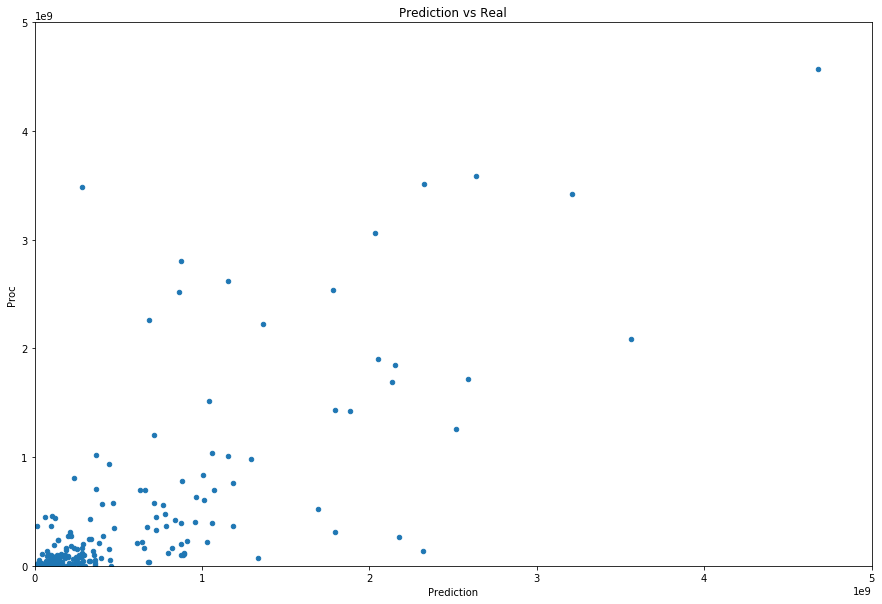

In [75]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Proc', figsize=(15,10), title='Prediction vs Real', 
                 ylim=(0,5000000000), xlim=(0,5000000000))

(60000000000, 200000000000)

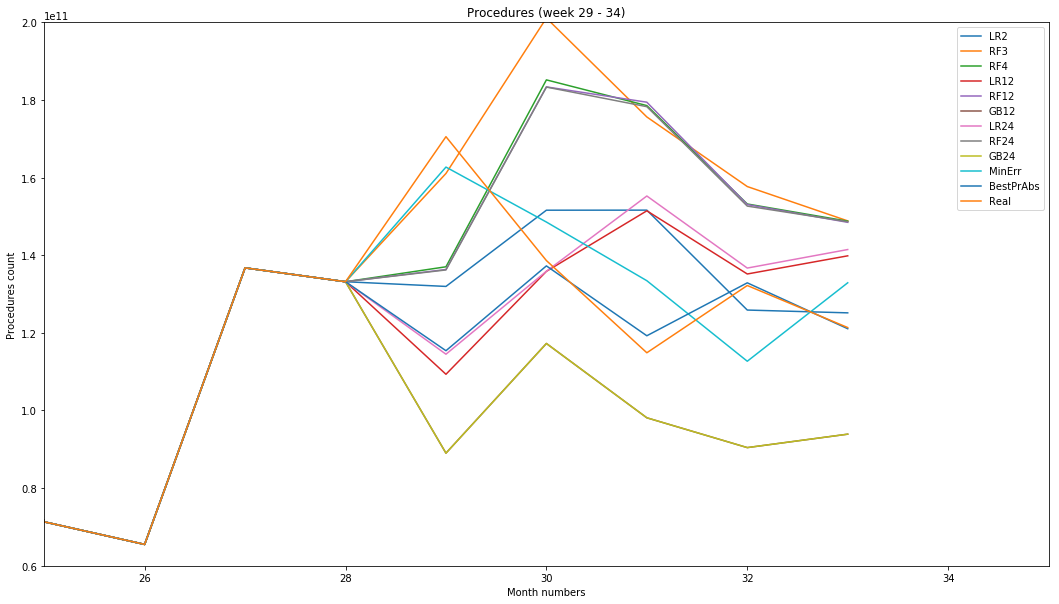

In [65]:
plt.plot(predict_ProcLR2)
plt.plot(predict_ProcRF3)
plt.plot(predict_ProcRF4)
plt.plot(predict_ProcLR12)
plt.plot(predict_ProcRF12)
plt.plot(predict_ProcGB12)
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(bestPredictPorc_er)
plt.plot(bestPredictPorc_AbsEr)
plt.plot(proceduresAll)

plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR2', 'RF3', 'RF4', 'LR12', 'RF12', 'GB12', 'LR24', 'RF24', 'GB24', 'MinErr', 'BestPrAbs', 'Real'))
plt.xlim(25, 35)
plt.ylim(60000000000, 200000000000)

In [51]:
#Импортируем Plotly
from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [57]:
B = pd.DataFrame({'B': predict_ProcB})
LR2 = pd.DataFrame({'LR2': predict_ProcLR2})
CE2 = pd.DataFrame({'CE2': predict_ProcLR2})
RF3 = pd.DataFrame({'RF3': predict_ProcRF3})
RF4 = pd.DataFrame({'RF4': predict_ProcRF4})
LR12 = pd.DataFrame({'LR12': predict_ProcLR12})
RF12 = pd.DataFrame({'RF12': predict_ProcRF12})
GB12 = pd.DataFrame({'GB12': predict_ProcGB12})
LR24 = pd.DataFrame({'LR24': predict_ProcLR24})
RF24 = pd.DataFrame({'RF24': predict_ProcRF24})
GB24 = pd.DataFrame({'GB24': predict_ProcGB24})

BE = pd.DataFrame({'BE': bestPredictPorc_er})
BAE = pd.DataFrame({'BAE': bestPredictPorc_AbsEr})
REAL = pd.DataFrame({'REAL': proceduresAll})

In [58]:
B.reset_index(inplace=True)
LR2.reset_index(inplace=True)
CE2.reset_index(inplace=True)
RF3.reset_index(inplace=True)
RF4.reset_index(inplace=True)
LR12.reset_index(inplace=True)
RF12.reset_index(inplace=True)
GB12.reset_index(inplace=True)
LR24.reset_index(inplace=True)
RF24.reset_index(inplace=True)
GB24.reset_index(inplace=True)
BE.reset_index(inplace=True)
BAE.reset_index(inplace=True)
REAL.reset_index(inplace=True)

In [59]:
LR2=LR2.merge( B, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( CE2, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF3, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF4, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( LR12, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF12, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( GB12, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( LR24, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF24, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( GB24, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( BE, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( BAE, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( REAL, how = 'inner', left_on = 'index', right_on = 'index' )


In [60]:
LR2 = LR2.tail(10)

In [63]:
#Строим графики
trace0 = go.Scatter(
    x=LR2.index,
    y=LR2.LR2,
    name='LR2'
)

trace1 = go.Scatter(
    x=LR2.index,
    y=LR2.RF3,
    name='RF3'
)

trace2 = go.Scatter(
    x=LR2.index,
    y=LR2.RF4,
    name='RF4'
)

trace3 = go.Scatter(
    x=LR2.index,
    y=LR2.LR12,
    name='LR12'
)

trace4 = go.Scatter(
    x=LR2.index,
    y=LR2.RF12,
    name='RF12'
)

trace5 = go.Scatter(
    x=LR2.index,
    y=LR2.GB12,
    name='GB12'
)
trace6 = go.Scatter(
    x=LR2.index,
    y=LR2.LR24,
    name='LR24'
)

trace7 = go.Scatter(
    x=LR2.index,
    y=LR2.RF24,
    name='RF24'
)

trace8 = go.Scatter(
    x=LR2.index,
    y=LR2.GB24,
    name='GB24'
)
trace9 = go.Scatter(
    x=LR2.index,
    y=LR2.BE,
    name='BE'
)

trace10 = go.Scatter(
    x=LR2.index,
    y=LR2.BAE,
    name='BAE'
)

trace11 = go.Scatter(
    x=LR2.index,
    y=LR2.REAL,
    name='REAL'
)

trace12 = go.Scatter(
    x=LR2.index,
    y=LR2.B,
    name='BASELINE'
)
trace13 = go.Scatter(
    x=LR2.index,
    y=LR2.CE2,
    name='CE2'
)
data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9, trace10, trace13, trace12, trace11]
layout = {'title': 'Прогноз размещения'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)